## PREDICTING NBA SHOTS

In [1]:
# data modeling
import sklearn

# for checking prediction accuracy
from sklearn import metrics

# for evaluating model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve

# data processing
import numpy as np
import pandas as pd

# data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt

# turn off auto display chart
plt.ioff()

### Reading data, dropping usless tables, size optimisation, splitting into features and labels

In [45]:
# read train, test and split CSV and creating dataframe
train_features = pd.read_csv('train.csv')
val_features = pd.read_csv('val.csv')
test_features = pd.read_csv('test.csv')

# drop all usseless stuff, split into features and labels for each
train_features.drop(['FGM', 'SHOT_RESULT', 'GAME_ID', 'LOCATION', 'W', 'W_DUM', 'GAME_CLOCK', 'SHOT_CLOCK', 'CLOSEST_DEFENDER', 'player_name', 'PTS', 'FINAL_MARGIN', 'player_id', 'CLOSEST_DEFENDER_PLAYER_ID'], axis='columns', inplace=True)
val_features.drop(['FGM', 'SHOT_RESULT', 'GAME_ID', 'LOCATION', 'W', 'W_DUM', 'GAME_CLOCK', 'SHOT_CLOCK', 'CLOSEST_DEFENDER', 'player_name', 'PTS', 'FINAL_MARGIN', 'player_id', 'CLOSEST_DEFENDER_PLAYER_ID'], axis='columns', inplace=True)
test_features.drop(['FGM', 'SHOT_RESULT', 'GAME_ID', 'LOCATION', 'W', 'W_DUM', 'GAME_CLOCK', 'SHOT_CLOCK', 'CLOSEST_DEFENDER', 'player_name', 'PTS', 'FINAL_MARGIN', 'player_id', 'CLOSEST_DEFENDER_PLAYER_ID'], axis='columns', inplace=True)

# change size of each feature for all 3 files
# Train
int_columns = train_features.select_dtypes('integer').columns
float_columns = train_features.select_dtypes('float').columns
train_features[float_columns] = train_features[float_columns].apply(pd.to_numeric, downcast='float')
train_features[int_columns] = train_features[int_columns].apply(pd.to_numeric, downcast='integer')
# val
int_columns = val_features.select_dtypes('integer').columns
float_columns = val_features.select_dtypes('float').columns
val_features[float_columns] = val_features[float_columns].apply(pd.to_numeric, downcast='float')
val_features[int_columns] = val_features[int_columns].apply(pd.to_numeric, downcast='integer')
# Test
int_columns = test_features.select_dtypes('integer').columns
float_columns = test_features.select_dtypes('float').columns
test_features[float_columns] = test_features[float_columns].apply(pd.to_numeric, downcast='float')
test_features[int_columns] = test_features[int_columns].apply(pd.to_numeric, downcast='integer')

# assign split into features and labels
train_labels = train_features['SHOT_RES_DUM']
val_labels = val_features['SHOT_RES_DUM']
test_labels = test_features['SHOT_RES_DUM']

train_features.drop(['SHOT_RES_DUM'], axis='columns', inplace=True)
val_features.drop(['SHOT_RES_DUM'], axis='columns', inplace=True)
test_features.drop(['SHOT_RES_DUM'], axis='columns', inplace=True)

# drop other useless stuff
train_features.drop(['PTS_TYPE', 'LOCATION_DUM', 'DRIBBLES'], axis='columns', inplace=True)
val_features.drop(['PTS_TYPE', 'LOCATION_DUM', 'DRIBBLES'], axis='columns', inplace=True)
test_features.drop(['PTS_TYPE', 'LOCATION_DUM', 'DRIBBLES'], axis='columns', inplace=True)

# Random Forest

#### Create model + model training

Random forest docs:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

feature importance
https://mljar.com/blog/feature-importance-in-random-forest/

testing with different parameters (and plotting)
https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#:~:text=The%20out%2Dof%2Dbag%20(,whilst%20being%20trained%20%5B1%5D

grid search CV for hyperparameter tuning
GridSearchCV

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
# Create model w parameter
rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', class_weight = {1: 1, 0: 10}
                                 # max_depth = , min_samples = , min_samples_leaf = , max_leaf_nodes = , min_impurity_decrease = , bootstrap = ,  max_features = ,  oob_score = ,
                                 #random_state = 42
                                )

# training model
rf_model.fit(train_features, train_labels)

RandomForestClassifier(class_weight={0: 10, 1: 1})

#### Test with test data

In [21]:
# Make predictions 
predictions_rf = rf_model.predict(val_features)

# Get prediction probabilities
predic_prob_rf = rf_model.predict_proba(val_features)[:, 1]

#### Evaluation (Random Forest)

In [22]:
# print accuracy score
print(f"Accuracy = {metrics.accuracy_score(val_labels, predictions_rf):.3f}%")

# print AUC
print (f"\nAUC: {metrics.roc_auc_score(val_labels, predic_prob_rf):.3f}")

# Print classification report
print(classification_report(val_labels, predictions_rf))

Accuracy = 0.617%

AUC: 0.682
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      8955
           1       0.61      0.64      0.62      8937

    accuracy                           0.62     17892
   macro avg       0.62      0.62      0.62     17892
weighted avg       0.62      0.62      0.62     17892



Confusion matrix

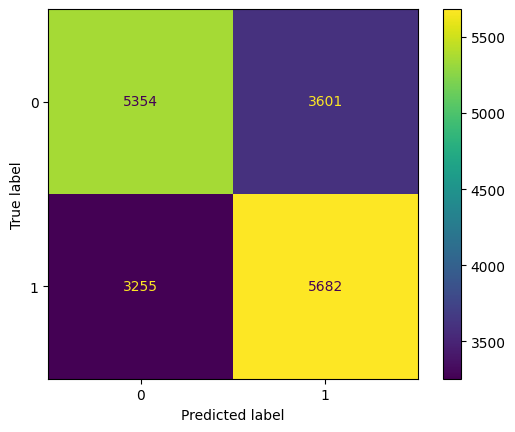

In [23]:
# Plot the confusion matrix in graph
cm_rf = confusion_matrix(val_labels,predictions_rf, labels=rf_model.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp.plot()

#### Feature importance

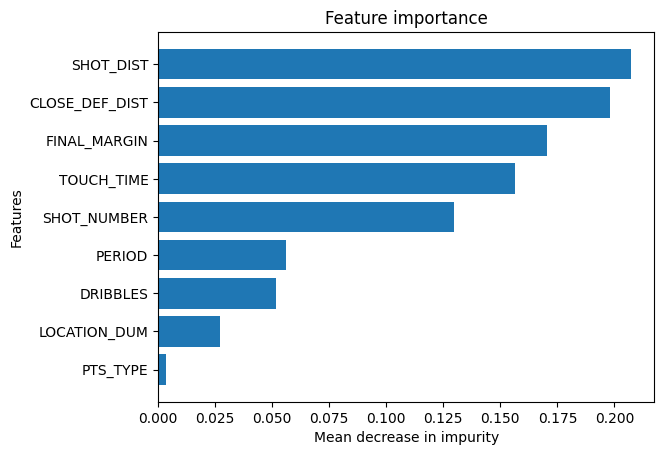

In [47]:
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(train_features.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.ylabel("Features")
plt.xlabel("Mean decrease in impurity")
plt.title("Feature importance")
plt.show()

# XGBOOST

youtube vid
https://www.youtube.com/watch?v=rMeq9khzdvM

In [25]:
import xgboost

In [26]:
# INSTANTIATE MODEL WITH PARAMETERS
xgboost_model = xgboost.XGBClassifier(
                          learning_rate=0.1, n_estimators = 100, subsample=0.5, 
                          colsample_bytree = 0.5, eval_metric = 'auc',
                          verbosity=0
                          )


eval_set = [(val_features, val_labels)]


# TRAIN MODEL
xgboost_model.fit(train_features, train_labels,
                  early_stopping_rounds = 10, eval_set = eval_set, verbose = False)

c:\Users\loh_h\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
# Make predictions 
predictions_xgb = xgboost_model.predict(test_features)

# Get prediction probabilities
predic_prob_xgb = xgboost_model.predict_proba(test_features)[:, 1]

#### Evaluation (XGBOOST)

In [28]:
# print accuracy score
print(f"Accuracy = {metrics.accuracy_score(test_labels, predictions_xgb):.3f}%")

# print AUC
print (f"\nAUC: {metrics.roc_auc_score(test_labels, predic_prob_xgb):.3f}")

# Print classification report
print(classification_report(test_labels, predictions_xgb))

Accuracy = 0.602%

AUC: 0.644
              precision    recall  f1-score   support

           0       0.58      0.73      0.65     10440
           1       0.64      0.48      0.55     10610

    accuracy                           0.60     21050
   macro avg       0.61      0.60      0.60     21050
weighted avg       0.61      0.60      0.60     21050



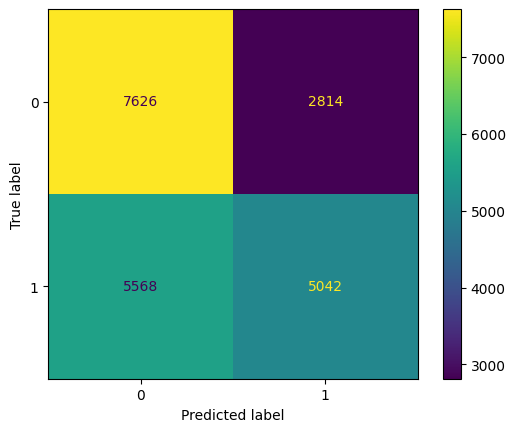

In [29]:
# Plot the confusion matrix in graph
cm_xgb = confusion_matrix(test_labels,predictions_xgb, labels=xgboost_model.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgboost_model.classes_)
disp.plot()

### Feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

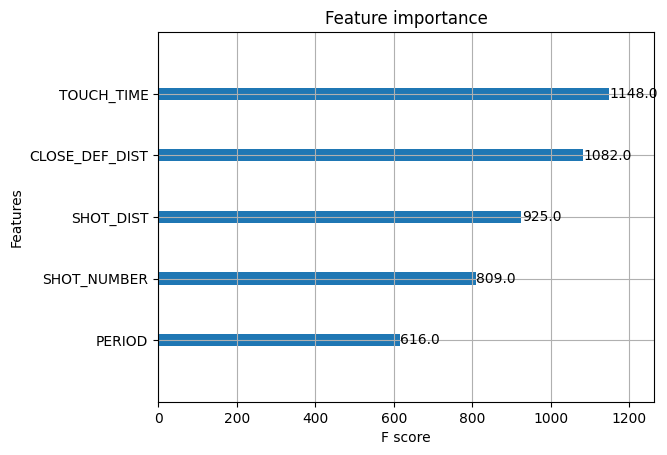

In [30]:
from xgboost import plot_importance
plot_importance(xgboost_model)

# ADABOOST

youtube vid
https://www.youtube.com/watch?v=rMeq9khzdvM

In [31]:
from sklearn.ensemble import AdaBoostClassifier

In [32]:
# INSTANTIATE MODEL WITH PARAMETERS
adaboost_model = AdaBoostClassifier(n_estimators = 100,
                                    learning_rate = 1)

In [33]:
# train adaboost classifer
adaboost_model.fit(train_features, train_labels)

AdaBoostClassifier(learning_rate=1, n_estimators=100)

#### Test with test data

In [34]:
# Make predictions 
predictions_ada = adaboost_model.predict(test_features)

# Get prediction probabilities
predic_prob_ada = adaboost_model.predict_proba(test_features)[:, 1]

#### Evaluation (ADA BOOST)

In [35]:
# print accuracy score
print(f"Accuracy = {metrics.accuracy_score(test_labels, predictions_ada):.3f}%")

# print AUC
print (f"\nAUC: {metrics.roc_auc_score(test_labels, predic_prob_ada):.3f}")

# Print classification report
print(classification_report(test_labels, predictions_ada))

Accuracy = 0.604%

AUC: 0.644
              precision    recall  f1-score   support

           0       0.59      0.68      0.63     10440
           1       0.63      0.53      0.58     10610

    accuracy                           0.60     21050
   macro avg       0.61      0.60      0.60     21050
weighted avg       0.61      0.60      0.60     21050



Confusion matrix

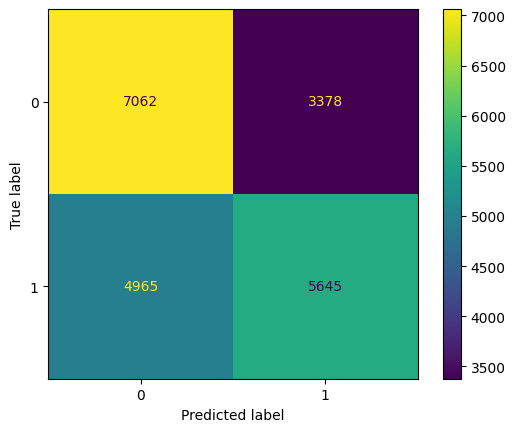

In [36]:
# Plot the confusion matrix in graph
cm_ada = confusion_matrix(test_labels,predictions_ada, labels=adaboost_model.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=adaboost_model.classes_)
disp.plot()

## ENSEMBLE 1

In [37]:
# get new predictions by aggregating all 3
predictions_ensemble = []

for i, pred in enumerate(predictions_rf):
  item = (predictions_rf[i] + predictions_xgb[i] + predictions_ada[i])
  
  if (item == 0):
    item = 0
  elif (item == 1):
    item = 1
  elif (item == 2):
    item = 1
  elif (item == 3):
    item = 1
  
  predictions_ensemble.append(item)

#### Evaluate

In [39]:
# print accuracy score
print(f"Accuracy = {metrics.accuracy_score(test_labels, predictions_ensemble):.3f}%")

# print AUC

# Print classification report
print(classification_report(test_labels, predictions_ensemble))

ValueError: Found input variables with inconsistent numbers of samples: [21050, 17892]

In [ ]:
print(f"Accuracy = {metrics.accuracy_score(test_labels, predictions_ensemble)}")

NameError: name 'predictions_ensemble' is not defined

In [ ]:
# Plot the confusion matrix in graph
cm = confusion_matrix(test_labels,predictions_ensemble, labels=adaboost_model.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost_model.classes_)
disp.plot()

## ENSEMBLE 2

In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
combi_model = VotingClassifier( estimators=[('rf', rf_model), ('xgb', xgboost_model), ('ada', adaboost_model)], voting = 'soft' )

# train adaboost classifer
combi_model.fit(train_features, train_labels)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight={0: 10,
                                                                   1: 1})),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc', gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0,
                                            reg_alpha=0, reg_lambda=1, ...)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=1,
                                                 n_estimators=100))])

#### Test with test data

In [43]:
# Make predictions 
predictions_combi = combi_model.predict(test_features)

# Get prediction probabilities
predic_prob_combi = combi_model.predict_proba(test_features)[:, 1]

### Evaluation (Combi)

In [44]:
# print accuracy score
print(f"Accuracy = {metrics.accuracy_score(test_labels, predictions_combi):.3f}%")

# print AUC
print (f"\nAUC: {metrics.roc_auc_score(test_labels, predic_prob_combi):.3f}")

# Print classification report
print(classification_report(test_labels, predictions_combi))

Accuracy = 0.611%
              precision    recall  f1-score   support

           0       0.59      0.71      0.64     10440
           1       0.64      0.51      0.57     10610

    accuracy                           0.61     21050
   macro avg       0.62      0.61      0.61     21050
weighted avg       0.62      0.61      0.61     21050



Confusion matrix

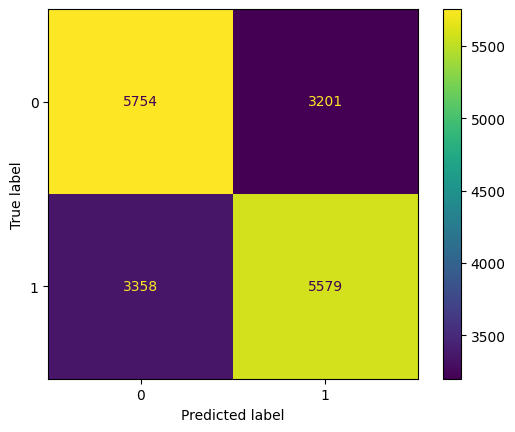

In [ ]:
# Plot the confusion matrix in graph
cm = confusion_matrix(test_labels,predictions_combi, labels=combi_model.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=combi_model.classes_)
disp.plot()

## Plot 4 models on 1 plot

In [ ]:
# combi
fpr, tpr, _ = roc_curve(test_labels, predictions_combi)
auc_combi = round(roc_auc_score(test_labels, predic_prob_combi), 2)
plt.plot(fpr,tpr,label="Combi, AUC=" + str(auc_combi))

# random forest
fpr, tpr, _ = roc_curve(test_labels, predictions_rf)
auc_rf = round(roc_auc_score(test_labels, predic_prob_rf), 2)
plt.plot(fpr,tpr,label="Random Forest, AUC=" + str(auc_rf))

# xgboost
fpr, tpr, _ = roc_curve(test_labels, predictions_xgb)
auc_xgb = round(roc_auc_score(test_labels, predic_prob_xgb), 2)
plt.plot(fpr,tpr,label="XGboost, AUC=" + str(auc_xgb))

# ada boost
fpr, tpr, _ = roc_curve(test_labels, predictions_ada)
auc_ada = round(roc_auc_score(test_labels, predic_prob_ada), 2)
plt.plot(fpr,tpr,label="Adaboost, AUC=" + str(auc_ada))


# labels
plt.plot([0, 1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

In [ ]:
tn = 6811
fp = 3629
fn = 3828
tp = 6782

true_positive_rate = round((tp / (tp + fn))*100, 2)
true_negative_rate = round((tn / (tn + fp))*100, 2)
precision = round((tp / (tp + fp))*100,2)
recall = round(tp / (tp + fn) *100, 2)

print(f"true positive rate / sensitivity: {true_positive_rate}%")
print(f"true negative rate / specificity: {true_negative_rate}%")
print(f"precision: {precision}%")
print(f"recall: {recall}%")

true positive rate / sensitivity: 63.92%
true negative rate / specificity: 65.24%
precision: 65.14%
recall: 63.92%


In [ ]:
def learning_curves(estimator, data, features, target, train_sizes, cv):
   train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,40)

### Plotting the two learning curves ###

plt.figure(figsize = (16,5))

for model, i in [(rf_model, 1), (LinearRegression(),2)]:
    plt.subplot(1,2,i)
    learning_curves(model, electricity, features, target, train_sizes, 5)